In [2]:
# pip install POT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import warnings
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import multivariate_normal
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import percentileofscore
from itertools import product
import ot
from dim2_OT_inter import train

### prepare function

In [2]:
def margin(A):
    column_sum = np.sum(A, axis=0)
    row_sum = np.sum(A, axis=1)
    return (column_sum, row_sum)

def normalize(u):
    return u / np.sum(u)

def xi_matrix(n):
    xi = np.eye(n)
    xi[np.tril_indices(n, -1)] = 2
    return xi

def omega(n):
    omega_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            omega_matrix[i][j] = (2*n - 2*(i+1) + 1)*(2*n - 2*(j+1) + 1) / (n*n)
    return omega_matrix

def get_bistochastic_matrix(copula):
    rows = len(copula)
    clos = len(copula[0])
    A = np.zeros((rows, clos))
    A[0][0] = rows * copula[0][0]
    for i in range(1,rows):
        A[i][0] = rows * (copula[i][0]- copula[i-1][0])
    for j in range(1,clos):
        A[0][j] = rows * (copula[0][j] - copula[0][j-1])
    for i in range(1, rows):
        for j in range(1, clos):
            A[i][j] = rows * (copula[i][j] - copula[i-1][j] - copula[i][j-1] + copula[i-1][j-1])
    return A

def tau_function(A):
    '''
    A is the doubly stachastic matrix
    '''
    n = len(A)
    xi = xi_matrix(n)
    
    temp = np.trace(np.dot(np.dot(np.dot(xi, A), xi), A.T))
    return 1 - (temp / (n*n) )

def rho_function(A):
    '''
    A is doubly stochastic matrix
    '''
    n = len(A)
    omega_matrix = omega(n)
    temp = np.trace(np.dot(omega_matrix, A))
    return 3 * temp / n - 3

# def Cost_matrix(n):
#     center_row = np.arange(1, 2*n, 2, dtype=np.float64)
#     centers_li = np.array(list(product(center_row,repeat=2)))
#     cost_matrix = ot.dist(centers_li,centers_li, metric='euclidean', p=2, w=None) / (2*n)
#     return cost_matrix

def L2_distance(n):
    center_row = np.arange(1, 2*n, 2, dtype=np.float64)
    centers_li = np.array(list(product(center_row,repeat=2)))
    cost_matrix = ot.dist(centers_li / (2*n),centers_li / (2*n), metric='sqeuclidean', p=2, w=None) 
    return cost_matrix

def L1_distance(n):
    center_row = np.arange(1, 2*n, 2, dtype=np.float64)
    centers_li = np.array(list(product(center_row,repeat=2)))
    cost_matrix = ot.dist(centers_li / (2*n),centers_li / (2*n), metric='cityblock', p=2, w=None) 
    return cost_matrix

### continuous interpolation

In [3]:
def min_matrix(Z):
    return np.min(Z),np.unravel_index(np.argmin(Z), Z.shape)

def max_matrix_row(Z, i):
    return np.max(Z[i]), np.argmax(Z[i])

def min_matrix_row(Z, i):
    return np.min(Z[i]), np.argmin(Z[i])

def min_mtrix_col(Z, j):
    return np.min(Z[:, j]), np.argmin(Z[:, j])

def transfer_matrix(n,i_1,i_2,j_1,j_2):
    Z = np.zeros((n, n))
    Z[i_1][j_1] += 1
    Z[i_2][j_2] += 1
    Z[i_1][j_2] -= 1
    Z[i_2][j_1] -= 1
    return Z

In [4]:
def specific_path_column(A, a, tau_list, rho_list, a_list, A_path, i, i_2, j, j_2, n):
    "Z_{i,j}>0, Z_{i_2,j_2}>0, Z_{i_2,j}<0, Z_{i,j_2}<0, j < j_2"
    A_copy = A.copy()
    A_copy[i_2, :] = A_copy.min() - 1
    a_temp = [a]
    indices = []
    for j_temp in range(j+1, j_2):
        value = np.max(A_copy[:, j_temp])
        index = np.argmax(A_copy[:, j_temp])
        a_temp.append(value)
        indices.append(index)
    a_local = min(a_temp)
    num_rep = a // a_local
    r = a - num_rep * a_local
    
    for temp in range(int(num_rep)):
        for j_temp in range(j, j_2-1):
            Z_transfer = transfer_matrix(n, indices[j_temp-j], i_2, j_temp, j_temp+1)
            A = A + a_local * Z_transfer
            tau_list.append(tau_function(A))
            rho_list.append(rho_function(A))
            a_list.append(a_local)
            A_path.append(A)
        Z_transfer = transfer_matrix(n, i, i_2, j_2-1, j_2)
        A = A + a_local * Z_transfer
        tau_list.append(tau_function(A))
        rho_list.append(rho_function(A))
        a_list.append(a_local)
        A_path.append(A)
        for j_temp in range(j_2-1, j, -1):
            if indices[len(indices)-j_2+j_temp] != i:
                Z_transfer = transfer_matrix(n, i, indices[len(indices)-j_2+j_temp], j_temp-1, j_temp)
                A = A + a_local * Z_transfer
                tau_list.append(tau_function(A))
                rho_list.append(rho_function(A))
                a_list.append(a_local)
                A_path.append(A)
    
    if r > 10**(-10):
        for j_temp in range(j, j_2-1):
            Z_transfer = transfer_matrix(n, indices[j_temp-j], i_2, j_temp, j_temp+1)
            A = A + r * Z_transfer
            tau_list.append(tau_function(A))
            rho_list.append(rho_function(A))
            a_list.append(r)
            A_path.append(A)
        Z_transfer = transfer_matrix(n, i, i_2, j_2-1, j_2)
        A = A + r * Z_transfer
        tau_list.append(tau_function(A))
        rho_list.append(rho_function(A))
        a_list.append(r)
        A_path.append(A)
        for j_temp in range(j_2-1, j, -1):
            if indices[len(indices)-j_2+j_temp] != i:
                Z_transfer = transfer_matrix(n, i, indices[len(indices)-j_2+j_temp], j_temp-1, j_temp)
                A = A + r * Z_transfer
                tau_list.append(tau_function(A))
                rho_list.append(rho_function(A))
                a_list.append(r)
                A_path.append(A)

    return A, tau_list, rho_list, a_list, A_path

In [5]:
epsilon_0 = 10 ** (-10)

def get_path(A, A_2):
    Z = A_2 - A
    size = len(A)
    A_path = []
    tau_list = []
    rho_list = []
    a_list = []

    i = 0
    while i < size-1:
        if np.min(Z[i,:]) < -epsilon_0*(i+1)*20:
            Zi_min, j = min_matrix_row(Z, i)
            Zi_max, j_temp = max_matrix_row(Z, i)
            Zj_min, i_temp = min_mtrix_col(Z, j_temp)
            a = min(-Zi_min, Zi_max, -Zj_min)
            if abs(i_temp - i) == 1 or abs(j - j_temp) == 1:
                Z_transfer = transfer_matrix(size, i, i_temp, j_temp, j)
                A = A + a * Z_transfer
                tau_list.append(tau_function(A))
                rho_list.append(rho_function(A))
                a_list.append(a)
                A_path.append(A)
                Z = Z - a * Z_transfer
            elif j_temp < j:
                A, tau_list, rho_list, a_list, A_path = specific_path_column(A, a, tau_list, rho_list, a_list, A_path, i, i_temp, j_temp, j, size)
                Z_transfer = transfer_matrix(size, i, i_temp, j_temp, j)
                Z = Z - a * Z_transfer
            elif j_temp > j:
                A, tau_list, rho_list, a_list, A_path = specific_path_column(A, a, tau_list, rho_list, a_list, A_path, i_temp, i, j, j_temp, size)
                Z_transfer = transfer_matrix(size, i, i_temp, j_temp, j)
                Z = Z - a * Z_transfer
        else:
            i = i + 1
    return A, tau_list, rho_list, a_list, A_path

In [6]:
def convert_to_copula(A):
    A = A/np.sum(A)
    A = np.insert(A, 0, 0, axis=0)
    A = np.insert(A, 0, 0, axis=1)
    f_x, f_y = margin(A)
    F_X = np.cumsum(f_x)
    F_Y = np.cumsum(f_y)
    
    n = len(A)
    x = np.linspace(0, 1, n)
    F_U_inv = interp1d(F_X, x, kind='linear')
    F_V_inv = interp1d(F_Y, x, kind='linear')
    
    H = np.cumsum(np.cumsum(A, axis=0), axis=1)
    h = RegularGridInterpolator((x, x), H.T)
    
    x = np.linspace(0, 1-10**(-10), n)
    X, Y = np.meshgrid(F_U_inv(x), F_V_inv(x))
    copula_matrix = h((X,Y))
    copula_density = copula_matrix[1:,1:]+copula_matrix[:-1,:-1]-copula_matrix[1:,:-1]-copula_matrix[:-1,1:]
    
    return copula_matrix[1:,1:], copula_density

In [7]:
def main(A_0, A_1, Q, N, P, iter_num, sigma, tau, theta, epsilon, optimal_transport=True):
    
    if optimal_transport:
        f0 = normalize(A_0)
        f1 = normalize(A_1)
        U,V = train(f0, f1, Q, N, P, iter_num, sigma, tau, theta, epsilon)
        if (U.M[0]).any() < -10**(-7):
            warnings.warn('Negative problem')
        U.M[0][U.M[0] < 0] = 0
        
        t_list_plt = np.array([0, Q//5, (Q*2)//5, (Q*3)//5, (Q*4)//5, Q])
        A_path_0 = (N**2) * convert_to_copula(U.M[0][t_list_plt[0]])[1]
        A_path_1 = (N**2) * convert_to_copula(U.M[0][t_list_plt[1]])[1]
        A_path_2 = (N**2) * convert_to_copula(U.M[0][t_list_plt[2]])[1]
        A_path_3 = (N**2) * convert_to_copula(U.M[0][t_list_plt[3]])[1]
        A_path_4 = (N**2) * convert_to_copula(U.M[0][t_list_plt[4]])[1]
        A_path_5 = (N**2) * convert_to_copula(U.M[0][t_list_plt[5]])[1]
        fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={'projection': '3d'})
        matrix_list = [A_path_0, A_path_1, A_path_2, A_path_3, A_path_4, A_path_5]
        titles = ['x=0'] + ['x='f'{np.round(t_list_plt[i]/Q,4)}' for i in range(1,5)] + ['x=1']
        for i, (matrix, title) in enumerate(zip(matrix_list, titles)):
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
            x = x.flatten()
            y = y.flatten()
            z = np.zeros_like(x)
            dx = dy = 0.7
            dz = matrix.flatten()
            ax.bar3d(x, y, z, dx, dy, dz, shade=False, color='yellow', edgecolor='black', linewidth=0.2)
            ax.set_title(f'{title}', fontsize=12)
            ax.view_init(elev=40, azim=40)
            ax.invert_xaxis()
            ax.set_ylim(ax.get_ylim()[::-1])
            ax.set_xticks([]) 
            ax.set_yticks([])
            ax.set_zlim(0, 12)
        plt.tight_layout()
        plt.savefig('Fig/interpolation.eps', format='eps')
        plt.savefig('Fig/interpolation-eps-converted-to.pdf', format='pdf')
        plt.show()
    
        copula_inter = np.zeros((Q+1,N,P))
        for i in range(Q+1):
            copula_inter[i,:,:] = N * convert_to_copula(U.M[0][i])[1]
        A0 = copula_inter[0,:,:]
        tau_all = [tau_function(A0)]
        rho_all = [rho_function(A0)]
        A_path_all = [A0]
        a_all = [0]
        i = 0
        n_index_list = [0]
        n_index = 0
        while i < Q:
            A, tau_list, rho_list, a_list, A_path =  get_path(copula_inter[i], copula_inter[i+1])
            n_index += len(tau_list)
            n_index_list.append(n_index)
            tau_all = tau_all + tau_list
            rho_all = rho_all + rho_list
            a_all = a_all + a_list
            A_path_all = A_path_all + A_path
            i += 1
        
        num_interp = 40
        sum_a_all = np.cumsum(a_all)
        c = np.linspace(0, np.sum(a_all[: n_index_list[1]]),num_interp+1)[:-1]
        avarage_indices = np.searchsorted(sum_a_all, c)
        for i in range(1,Q):
            c = np.linspace(np.sum(a_all[: n_index_list[i]]), np.sum(a_all[: n_index_list[i+1]]),num_interp+1)[:-1]
            temp = np.searchsorted(sum_a_all, c)
            avarage_indices = np.concatenate((avarage_indices, temp))
        avarage_indices = np.append(avarage_indices, n_index_list[-1])
        x = np.linspace(0, 1, Q*num_interp+1)
        tau_plot = [tau_all[i] for i in avarage_indices]
        rho_plot = [rho_all[i] for i in avarage_indices]
        A_equal_effort_plot = [A_path_all[i] for i in avarage_indices]
        wasseretrin2_copula_A1 = np.zeros(Q*num_interp+1)
        wasseretrin2_copula_A0 = np.zeros(Q*num_interp+1)
        wasseretrin1_copula_A1 = np.zeros(Q*num_interp+1)
        wasseretrin1_copula_A0 = np.zeros(Q*num_interp+1)
        temp_A0 = np.ravel(A_0)
        temp_A1 = np.ravel(A_1)
        cost_1 = L1_distance(N)
        cost_2 = L2_distance(N)
        for i in range(Q*num_interp+1):
            A = np.ravel(A_equal_effort_plot[i])
            a = A.sum()-N
            if a<0:
                A[np.argmin(A)] -= a
            else:
                A[np.argmax(A)] -= a
            A[A < 0] = 0
            wasseretrin2_copula_A1[i] = np.sqrt(ot.emd2(A, temp_A1, cost_2))
            wasseretrin2_copula_A0[i] = np.sqrt(ot.emd2(A, temp_A0, cost_2))
            wasseretrin1_copula_A1[i] = ot.emd2(A, temp_A1, cost_1)
            wasseretrin1_copula_A0[i] = ot.emd2(A, temp_A0, cost_1)

        wass2_intermatr_A1 = np.zeros(Q+1)
        wass2_intermatr_A0 = np.zeros(Q+1)
        wass1_intermatr_A1 = np.zeros(Q+1)
        wass1_intermatr_A0 = np.zeros(Q+1)
        for i in range(Q+1):
            A = np.ravel(N*U.M[0][i])
            a = A.sum()-N
            if a<0:
                A[np.argmin(A)] -= a
            else:
                A[np.argmax(A)] -= a
            wass2_intermatr_A0[i] = np.sqrt(ot.emd2(A, temp_A0, cost_2))
            wass2_intermatr_A1[i] = np.sqrt(ot.emd2(A, temp_A1, cost_2))
            wass1_intermatr_A0[i] = ot.emd2(A, temp_A0, cost_1)
            wass1_intermatr_A1[i] = ot.emd2(A, temp_A1, cost_1)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        ax1.plot(x, tau_plot, label=r'$\tau$', color='red')
        ax1.scatter(np.linspace(0, 1, Q+1), [tau_plot[int(i)] for i in np.linspace(0, Q*num_interp, Q+1)], color='black', zorder=5, s=10)
        ax1.legend()
        ax1.plot(x, rho_plot, label=r'$\rho$', color='blue')
        ax1.scatter(np.linspace(0, 1, Q+1), [rho_plot[int(i)] for i in np.linspace(0, Q*num_interp, Q+1)], color='black', zorder=5, s=10)
        ax1.set_title(r'Plot of $\tau$ and $\rho$')
        ax1.set_xlabel('t')
        ax1.legend()
        
        ax2.plot(x, wasseretrin2_copula_A1, label=r'$W_2$-distance to A_1', color='red')
        ax2.plot(x, wasseretrin2_copula_A0, label=r'$W_2$-distance to A_0', color='red', linestyle='--')
        ax2.plot(x, wasseretrin1_copula_A1, label=r'$W_1$-distance to A_1', color='blue')
        ax2.plot(x, wasseretrin1_copula_A0, label=r'$W_1$-distance to A_0', color='blue', linestyle='--')
        # ax2.scatter(np.linspace(0, 1, Q+1), wass2_intermatr_A0, color='black', zorder=5, s=10)
        ax2.scatter(np.linspace(0, 1, Q+1), wass2_intermatr_A1, color='black', zorder=5, s=10)
        # ax2.scatter(np.linspace(0, 1, Q+1), wass1_intermatr_A0, color='black', zorder=5, s=10)
        ax2.scatter(np.linspace(0, 1, Q+1), wass1_intermatr_A1, color='black', zorder=5, s=10)
        ax2.set_title(r'Wasserstein distance')
        ax2.set_xlabel('t')
        ax2.set_ylabel('distance')
        ax2.legend()
        plt.tight_layout()
        plt.savefig('Fig/interpolation_tau_rho.eps', format='eps')
        plt.savefig('Fig/interpolation_tau_rho-eps-converted-to.pdf', format='pdf')
        plt.show()
        
        return U.M[0], a_all, ot.emd2(temp_A1, temp_A0, cost_1)
    else:
        A, tau_list, rho_list, a_list, A_path =  get_path(A_0, A_1)
        tau_all = [tau_function(A_0)] + tau_list
        rho_all = [rho_function(A_0)] + rho_list
        a_all = [0] + a_list
        A_path = [A_0] + A_path
        num_interp = 100
        a_sum_list = np.cumsum(a_all)
        b = [np.sum(a_list)/num_interp * i for i in range(num_interp)]
        avarage_indices = np.searchsorted(a_sum_list, b)
        avarage_indices = np.append(avarage_indices, len(a_all)-1)
        
        tau_plot = [tau_all[i] for i in avarage_indices]
        rho_plot = [rho_all[i] for i in avarage_indices]
        A_equal_effort = [A_path[i] for i in avarage_indices]
        wasseretrin1_A0 = np.zeros(num_interp+1)
        wasseretrin1_A1 = np.zeros(num_interp+1)
        wasseretrin2_A0 = np.zeros(num_interp+1)
        wasseretrin2_A1 = np.zeros(num_interp+1)
        temp_A0 = np.ravel(A_0)
        temp_A1 = np.ravel(A_1)
        cost_1 = L1_distance(N)
        cost_2 = L2_distance(N)
        for i in range(num_interp+1):
            wasseretrin1_A0[i] = ot.emd2(np.ravel(A_equal_effort[i]), temp_A0, cost_1)
            wasseretrin1_A1[i] = ot.emd2(np.ravel(A_equal_effort[i]), temp_A1, cost_1)
            wasseretrin2_A0[i] = np.sqrt(ot.emd2(np.ravel(A_equal_effort[i]), temp_A0, cost_2))
            wasseretrin2_A1[i] = np.sqrt(ot.emd2(np.ravel(A_equal_effort[i]), temp_A1, cost_2))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        x = np.linspace(0, 1, num_interp+1)
        ax1.plot(x, tau_plot, label=r'$\tau$', color='red')
        ax1.plot(x, rho_plot, label=r'$\rho$', color='blue')
        ax1.set_title(r'Plot of $\tau$ and $\rho$')
        ax1.set_xlabel('x')
#         ax1.set_ylabel(r'$\tau$')
        ax1.legend()
        ax2.plot(x, wasseretrin1_A0, label=r'$W_1$-distance to A_0', color='blue', linestyle='--')
        ax2.plot(x, wasseretrin1_A1, label=r'$W_1$-distance to A_1', color='blue')
        ax2.plot(x, wasseretrin2_A0, label=r'$W_2$-distance to A_0', color='red', linestyle='--')
        ax2.plot(x, wasseretrin2_A1, label=r'$W_2$-distance to A_1', color='red')
        ax2.set_title(r'Wasserstein distance')
        ax2.set_xlabel('x')
        ax2.set_ylabel('distance')
        ax2.legend()
        plt.tight_layout()
        plt.savefig('Fig/direct_inter_taurho.eps', format='eps')
        plt.savefig('Fig/direct_inter_taurho-eps-converted-to.pdf', format='pdf')
        plt.show()
        
        t_list_plt = np.array([0, Q//5, (Q*2)//5, (Q*3)//5, (Q*4)//5, Q])
        A_path_0 = N * A_equal_effort[0]
        A_path_1 = N * A_equal_effort[num_interp//5]
        A_path_2 = N * A_equal_effort[2*num_interp//5]
        A_path_3 = N * A_equal_effort[3*num_interp//5]
        A_path_4 = N * A_equal_effort[4*num_interp//5]
        A_path_5 = N * A_equal_effort[5*num_interp//5]
        fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw={'projection': '3d'})
        matrix_list = [A_path_0, A_path_1, A_path_2, A_path_3, A_path_4, A_path_5]
        titles = ['x=0'] + ['x='f'{np.round(t_list_plt[i]/Q,4)}' for i in range(1,5)] + ['x=1']
        for i, (matrix, title) in enumerate(zip(matrix_list, titles)):
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
            x = x.flatten()
            y = y.flatten()
            z = np.zeros_like(x)
            dx = dy = 0.7
            dz = matrix.flatten()
            ax.bar3d(x, y, z, dx, dy, dz, shade=False, color='yellow', edgecolor='black', linewidth=0.2)
            ax.set_title(f'{title}', fontsize=12)
            ax.view_init(elev=40, azim=40)
            ax.invert_xaxis()
            ax.set_ylim(ax.get_ylim()[::-1])
            ax.set_xticks([]) 
            ax.set_yticks([])
            ax.set_zlim(0, 12)
        plt.tight_layout()
        plt.savefig('Fig/direct_inter.eps', format='eps')
        plt.savefig('Fig/direct_inter-eps-converted-to.pdf', format='pdf')
        plt.show()
    
    return a_list, ot.emd2(temp_A1, temp_A0, cost_1), tau_all, rho_all, A

In [8]:
# def Gaussian_copula_value(u,v,rho):
#     mean = [0,0]
#     covariance = [[1, rho], [rho, 1]]
#     two_dim_normal = multivariate_normal(mean, covariance)
#     point = np.array([norm.ppf(u,0,1), norm.ppf(v,0,1)])
#     return two_dim_normal.cdf(point)

# # def desity_gauss_copula(u,v,rho):
# #     x = norm.ppf(u,0,1)
# #     y = norm.ppf(v,0,1)
# #     a = 1 / (2 * math.pi * math.sqrt(1 - rho**2))
# #     b = 1 / (norm.pdf(x, 0, 1) * norm.pdf(y, 0, 1))
# #     c = math.pow(math.e, -(x**2+y**2-2*rho*x*y)/(2*(1-rho**2)))
# #     return a*b*c

# def discrete_gauss_copula(n,rho):
#     C = np.zeros((n,n))
#     for i in range(0,n):
#         for j in range(0,n):
#             C[i][j] = Gaussian_copula_value((i+1)/n,(j+1)/n,rho)
#     return C

# def Gumbel_copula(u,v,theta):
#     return np.exp( -( (-np.log(u))**theta + (-np.log(v))**theta )**(1/theta) )

# def discrete_gumbel_copula(n, theta):
#     C = np.zeros((n,n))
#     for i in range(0, n):
#         for j in range(0, n):
#             C[i][j] = Gumbel_copula((i+1)/n,(j+1)/n,theta)
#     return C

# def Clayton_copula(u,v,theta):
#     return np.maximum(0, ( u**(-theta) + v**(-theta) - 1 )**(-1/theta))

# def discrete_clayton_copula(n, theta):
#     C = np.zeros((n,n))
#     for i in range(0, n):
#         for j in range(0, n):
#             C[i][j] = Clayton_copula((i+1)/n,(j+1)/n,theta)
#     return C
# Clayton_copula(0.2,0.4,3)

In [9]:
from statsmodels.distributions.copula.api import ClaytonCopula, FrankCopula, ClaytonCopula, GumbelCopula
from statsmodels.distributions.copula.api import GaussianCopula, StudentTCopula, IndependenceCopula

def discrete_clayton_copula(n, theta):
    clayton = ClaytonCopula(theta=theta, k_dim=2)
    C = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            C[i][j] = clayton.cdf([(i+1)/n,(j+1)/n])
    return C

def discrete_gauss_copula(n,rho):
    gaussian = GaussianCopula(corr=rho, k_dim=2)
    C = np.zeros((n,n))
    for i in range(0,n):
        for j in range(0,n):
            C[i][j] = gaussian.cdf([(i+1)/n,(j+1)/n])
    return C

def discrete_gumbel_copula(n, theta):
    gumbel = GumbelCopula(theta=theta, k_dim=2)
    C = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            C[i][j] = gumbel.cdf([(i+1)/n,(j+1)/n])
    return C

def discrete_frank_copula(n, theta):
    frank = FrankCopula(theta=theta, k_dim=2)
    C = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            C[i][j] = frank.cdf([(i+1)/n,(j+1)/n])
    return C

def discrete_student_copula(n, rho, df):
    student = StudentTCopula(corr=rho, df=df, k_dim=2)
    C = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            C[i][j] = student.cdf([(i+1)/n,(j+1)/n])
    return C

def discrete_independence_copula(n):
    independence = IndependenceCopula(k_dim=2)
    C = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            C[i][j] = independence.cdf([(i+1)/n,(j+1)/n])
    return C

In [10]:
N = 20
Q = 40
P = 20
# N = 10
# Q = 10
# P = 10
d = [Q,N,P]
L = 1
sigma=85
tau = 0.99 / (sigma*L)
iter_num = 2000
theta = 1
epsilon = 10**(-15)
Copula_0 = discrete_gauss_copula(N,rho=0.8)
# Copula_0 = discrete_clayton_copula(N, theta = 7)
# Copula_0 = discrete_frank_copula(N, theta = -5)
# Copula_1 = discrete_gauss_copula(N,rho=-0.8)
# Copula_1 = discrete_clayton_copula(N, theta = 7)
Copula_1 = discrete_gumbel_copula(N, theta = 2.3)
# Copula_1 = discrete_independence_copula(N)
A0 = get_bistochastic_matrix(Copula_0)
A1 = get_bistochastic_matrix(Copula_1)
tau_function(A0), tau_function(A1)

(np.float64(0.5838485672135256), np.float64(0.5586999109114874))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


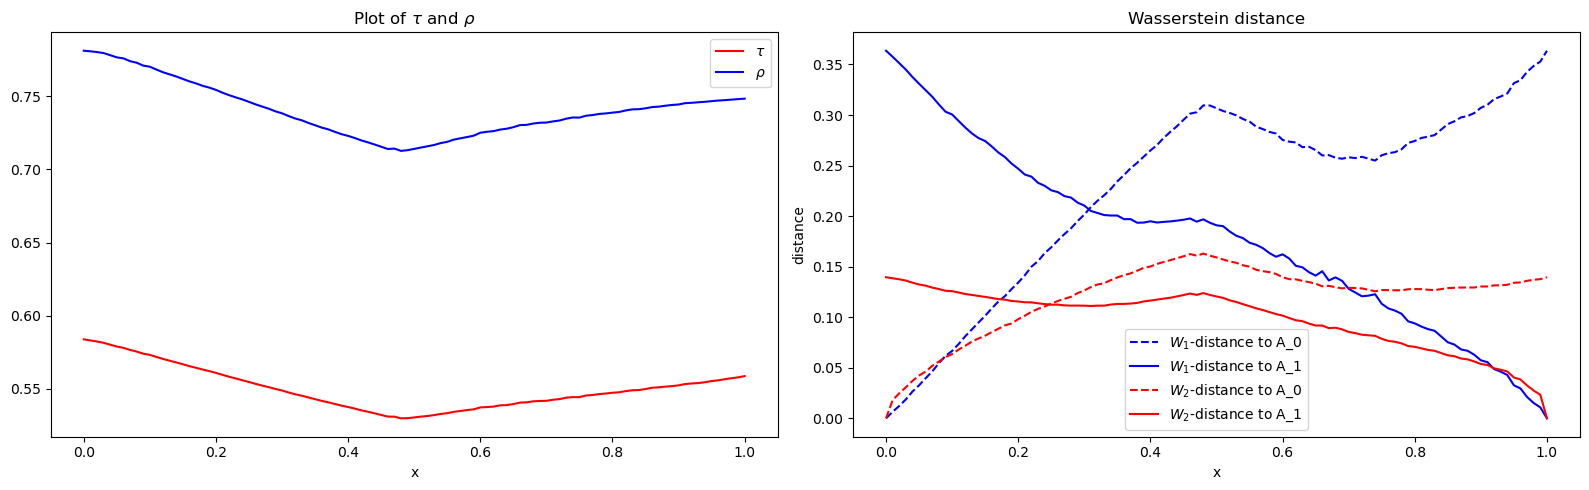

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


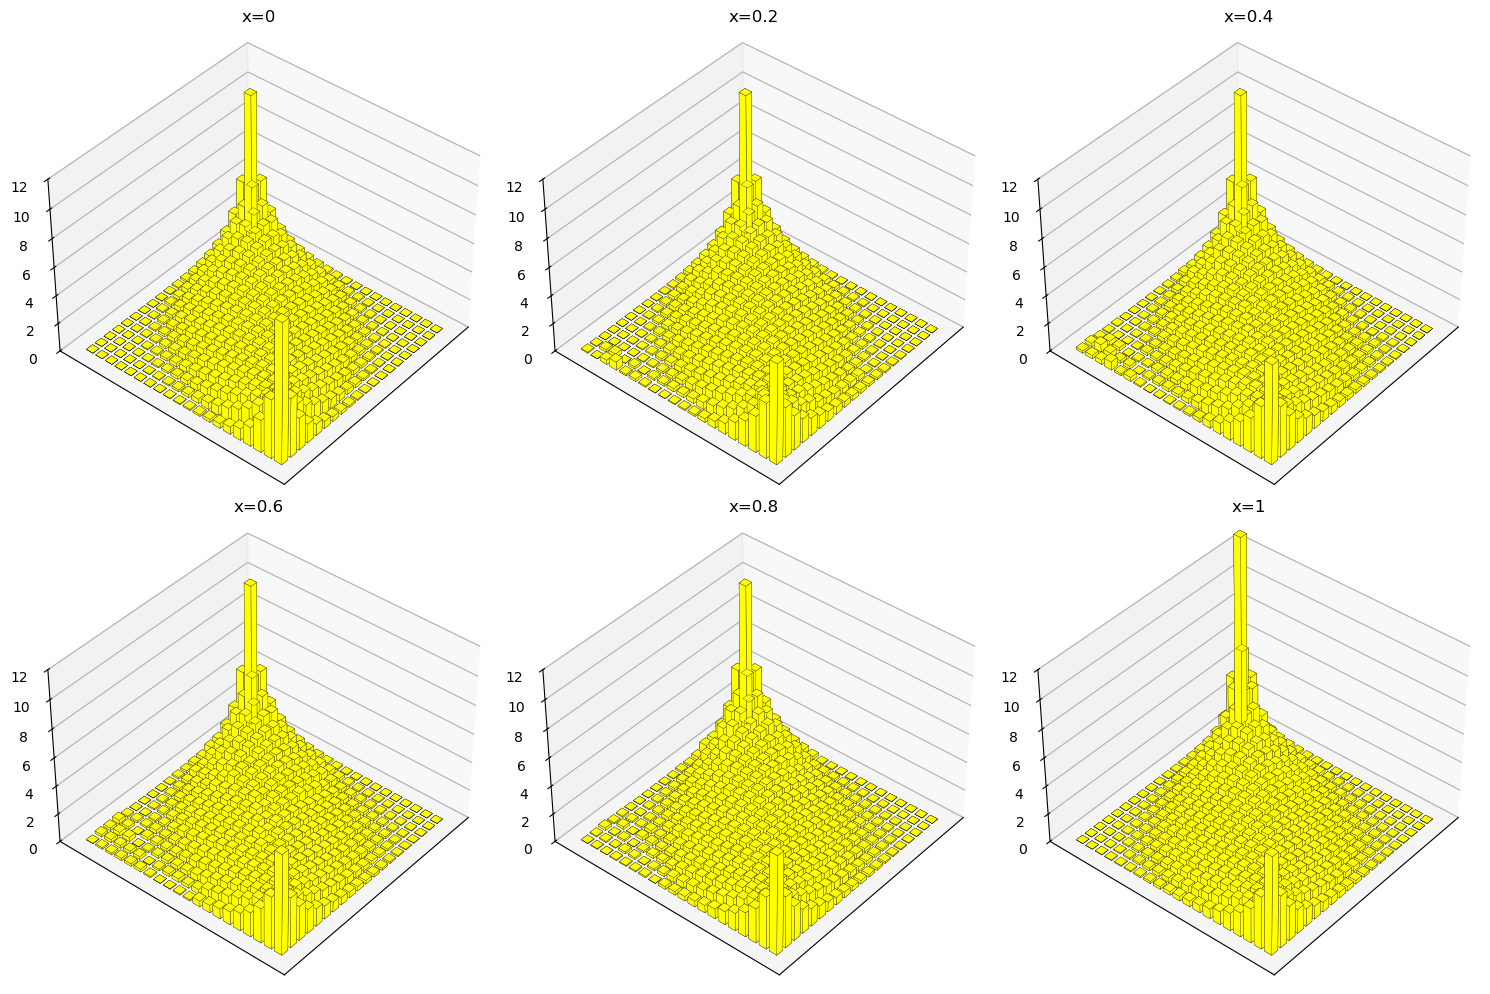

In [11]:
a_list, Wasser1,tau_all, rho_all, A = main(A0, A1, Q, N, P, iter_num, sigma, tau, theta, epsilon, optimal_transport=False)

In [12]:
np.abs(A-A1).max()

np.float64(9.145462165349727e-15)

In [13]:
len(a_list), Wasser1, sum(a_list)*2/20, sum(a_list)

(5570,
 0.3636172365084529,
 np.float64(1.3370080430606093),
 np.float64(13.370080430606093))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


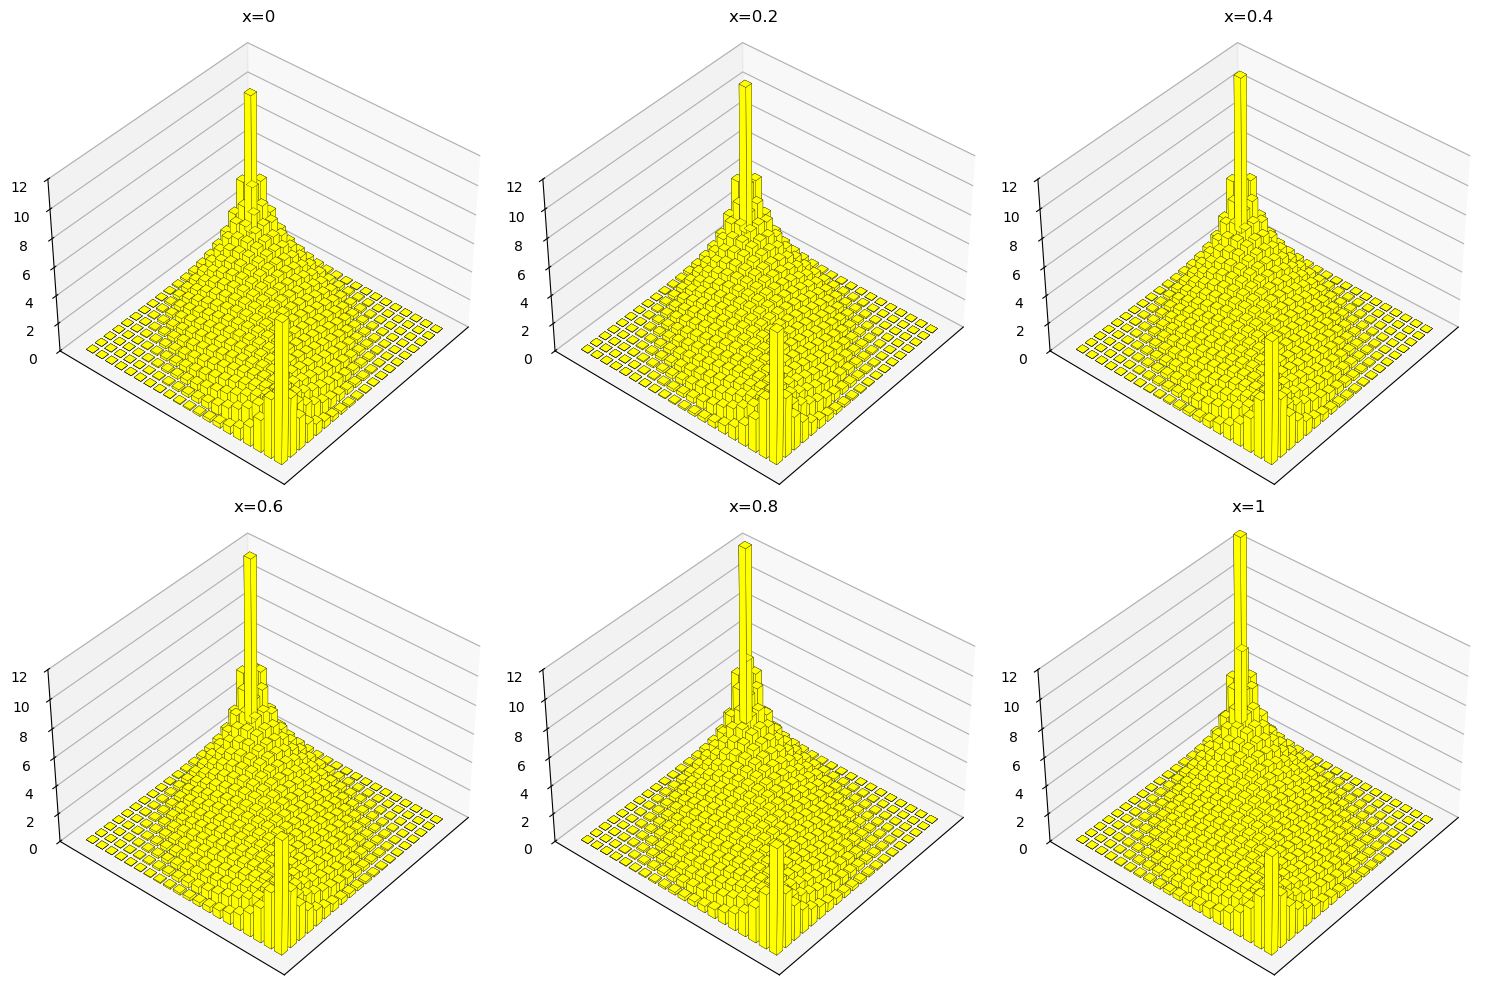

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


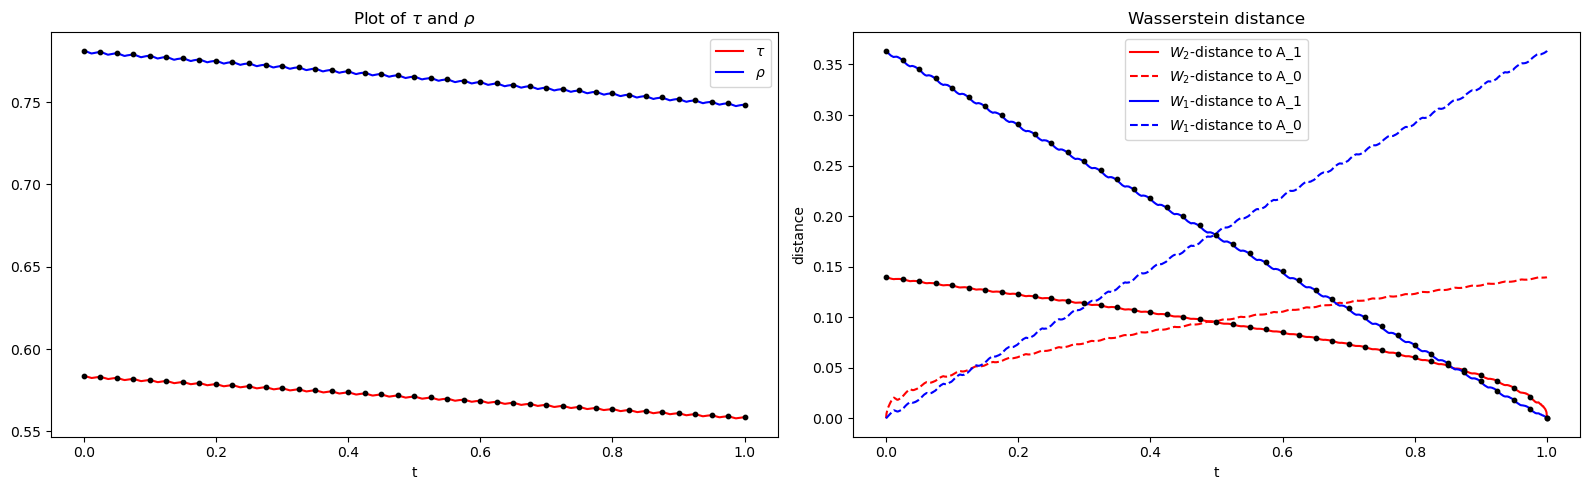

In [14]:
inter_matrix, a_all, Wasser1= main(A0, A1, Q, N, P, iter_num, sigma, tau, theta, epsilon, optimal_transport=True)

In [15]:
len(a_all), sum(a_all)*2/20

(228094, np.float64(1.3696034058488202))

### example: engine

In [16]:
sim_501640 = scipy.io.loadmat('02_Estimation_t2000test/usim_501640.mat')
sim_901640 = scipy.io.loadmat('02_Estimation_t2000test/usim_901640.mat')

y_position_501640 = sim_501640['usim'][:,2]
x_velocity_501640 = sim_501640['usim'][:,3]
y_position_901640 = sim_901640['usim'][:,2]
x_velocity_901640 = sim_901640['usim'][:,3]
#len(y_position_501640)=1242, len(y_position_901640)=2191
# print(len(y_position_501640),len(y_position_901640), 1240/20, 2180/20)
y_position_501640 = y_position_501640[:len(y_position_501640)-2]
x_velocity_501640 = x_velocity_501640[:len(x_velocity_501640)-2]
y_position_901640 = y_position_901640[:len(y_position_901640)-11]
x_velocity_901640 = x_velocity_901640[:len(x_velocity_901640)-11]

pseudo_y_position_501640 = percentileofscore(y_position_501640, y_position_501640, kind='weak') / 100
pseudo_x_velocity_501640 = percentileofscore(x_velocity_501640, x_velocity_501640, kind='weak') / 100
pseudo_y_position_901640 = percentileofscore(y_position_901640, y_position_901640, kind='weak') / 100
pseudo_x_velocity_901640 = percentileofscore(x_velocity_901640, x_velocity_901640, kind='weak') / 100
unit_square = [(0, 0), (1, 0), (1, 1), (0, 1)]

n = 20
xedges = [0] + [i/n + 10**(-8) for i in range(1, n)] + [1]
yedges = [0] + [i/n + 10**(-8) for i in range(1, n)] + [1]

# xedges = [0, 0.1+epsilon, 0.2+epsilon, 0.3+epsilon, 0.4+epsilon, 0.5+epsilon, 0.6+epsilon, 0.7+epsilon, 0.8+epsilon, 0.9+epsilon, 1]
# yedges = [0, 0.1+epsilon, 0.2+epsilon, 0.3+epsilon, 0.4+epsilon, 0.5+epsilon, 0.6+epsilon, 0.7+epsilon, 0.8+epsilon, 0.9+epsilon, 1]

hist_501640, xedges, yedges = np.histogram2d(pseudo_x_velocity_501640, pseudo_y_position_501640, bins=(xedges, yedges))
hist_901640, xedges, yedges = np.histogram2d(pseudo_x_velocity_901640, pseudo_y_position_901640, bins=(xedges, yedges))

A_0 = (hist_501640+10**(-8)) / len(x_velocity_501640) * n
A_1 = (hist_901640+10**(-8)) / len(x_velocity_901640) * n
# print(margin(A_1))

f0 = normalize(A_0)
f1 = normalize(A_1)
Q=20
N=n
P=n
d = [Q, N, P]

L = 1
sigma=85
tau = 0.99 / (sigma*L*100)
iter_num = 2000
theta = 1
epsilon = 10**(-15)


In [17]:
y_position_501640.shape

(1240,)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


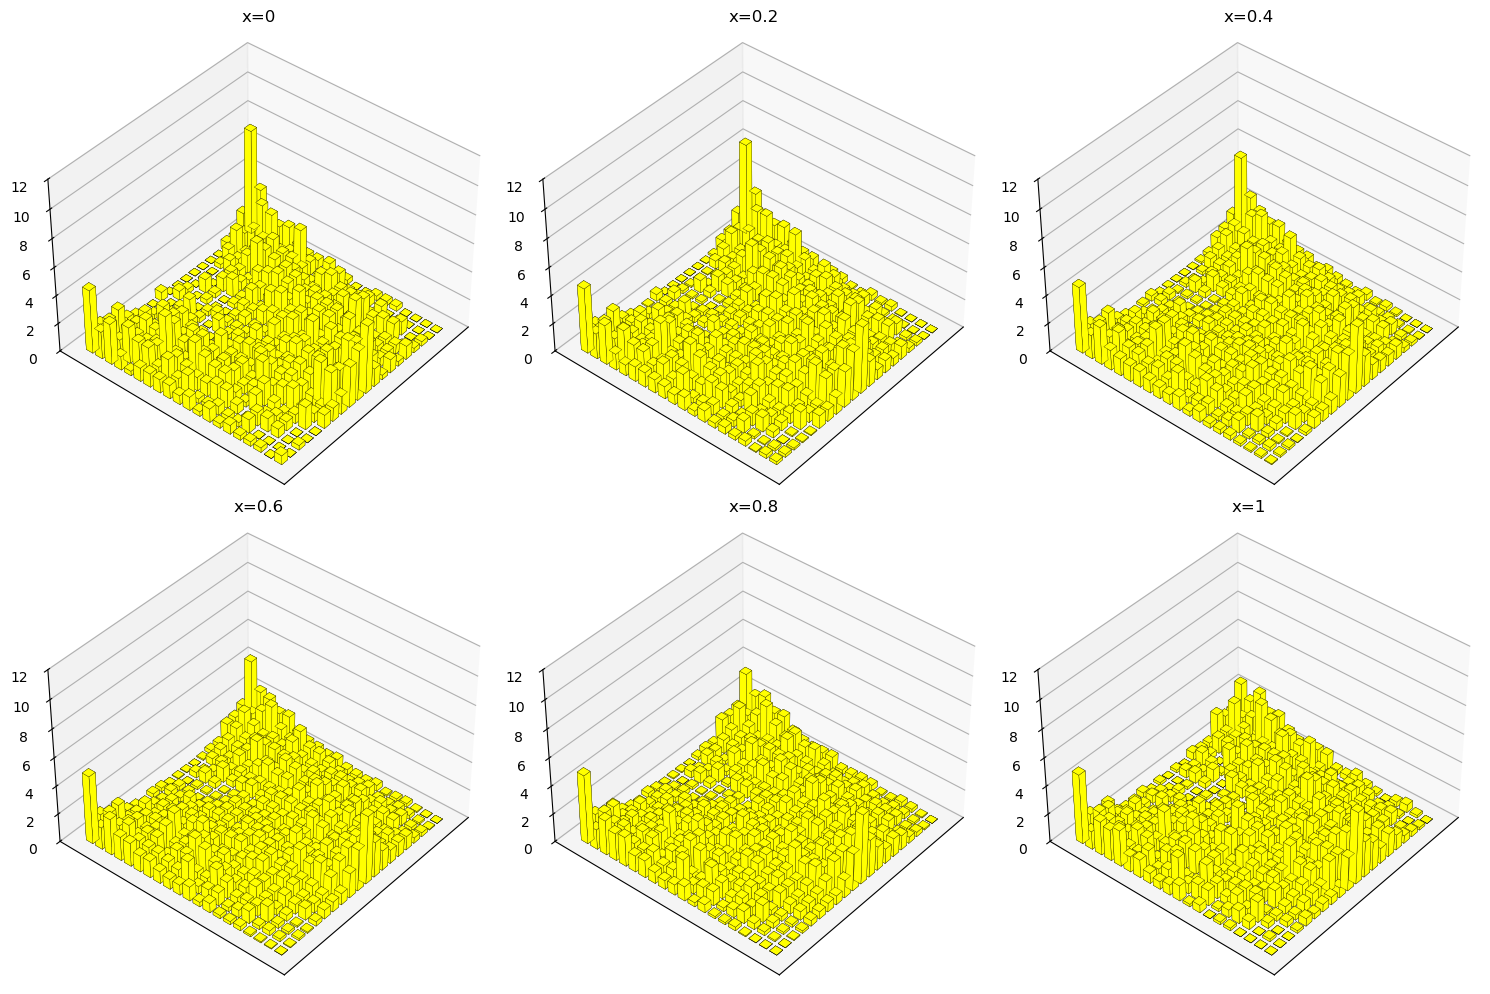

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


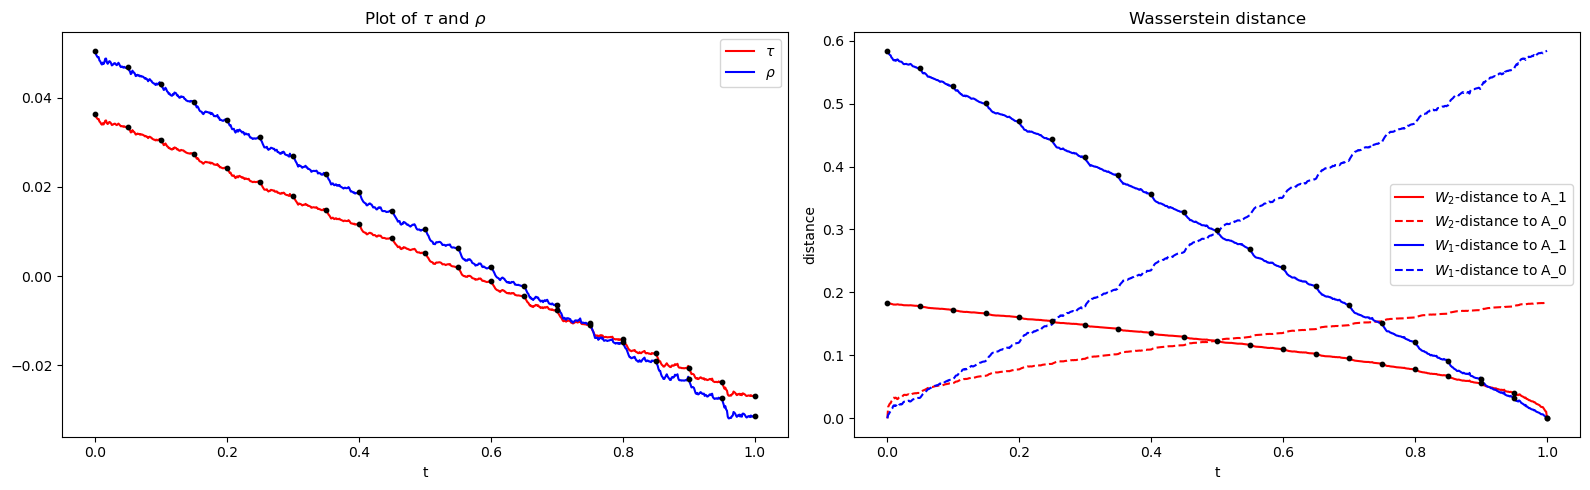

In [18]:
inter_matrix, a_all, Wasser1= main(A_0, A_1, Q, N, P, iter_num, sigma, tau, theta, epsilon, optimal_transport=True)

In [20]:
len(a_all), sum(a_all)*2/20

(83587, np.float64(4.533341262677219))